[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Poirazi-Lab/DendroTweaks/blob/main/tutorials/Reduction.ipynb)

In this tutorial, we will learn how to reduce a subtree of a neuron to a single equivalent cylinder. We will also see how to map the parameters of the original segments to the reduced segments.

We will follow the analytical impedance-based approach proposed by Amsalem et al., 2020. We have integrated this reduction algorithm in DendroTweaks and extended its functionality to allow for a continuum of morphology reduction levels, bridging detailed and “ball-and-stick”-like models. You can select any section of the cell and reduce its subtree, which allows for any intermediate level of detail to be achieved.

In [1]:
# !pip install dendrotweaks --quiet

If you are using Google Colab, you might also need to restart the session as the installation downgraded some packages (numpy). You can do it manually or programmatically as shown below:

In [2]:
# import os
# os.kill(os.getpid(), 9)

Let's begin by importing the standard libraries and the dendrotweaks library.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
import dendrotweaks as dd
dd.__version__

'0.4.2'

In [5]:
dd.apply_dark_theme() # Set the theme for the plots

In [ ]:
os.makedirs('examples', exist_ok=True)
if not os.listdir('examples/'):
    print("Downloading example data...")
    dd.download_example_data('examples')

Let's create a model:

In [6]:
path_to_model = os.path.join('examples', 'Park_2019')
print(f'Path to model: {path_to_model}')

Path to model: examples/Park_2019


In [7]:
model = dd.Model(path_to_model)

In [8]:
model.list_morphologies()

['Park_2019_sorted', 'Park_2019']

In [9]:
model.load_morphology(file_name='Park_2019')

Sorted PointTree(root=Point(idx=0), num_nodes=2214).
Extended 44 nodes.
Sorted PointTree(root=Point(idx=0), num_nodes=2258).


First, we need to visualize the section tree of our model.

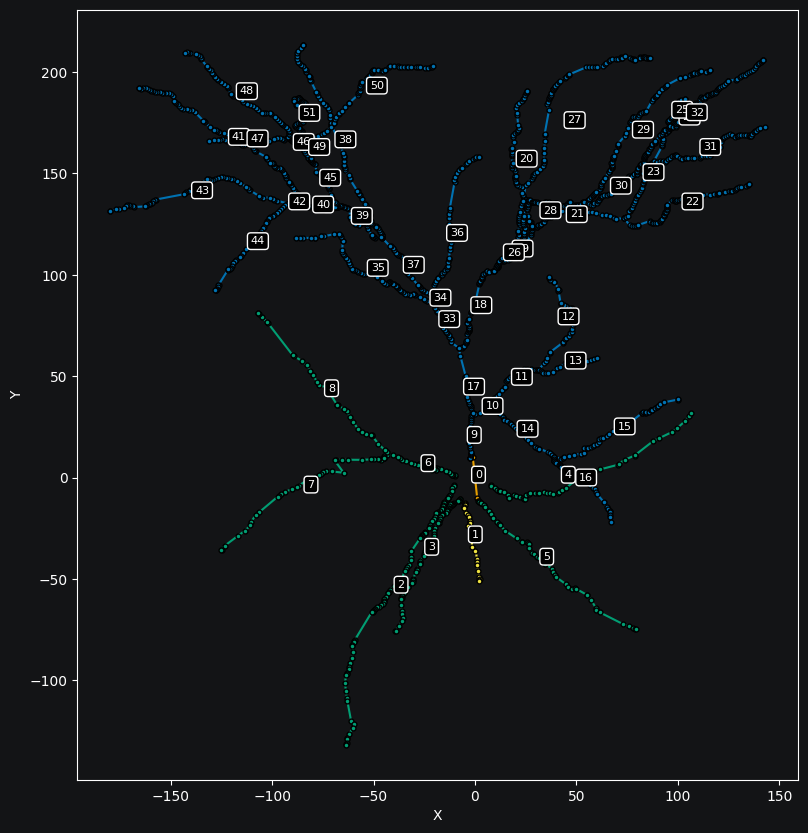

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
model.sec_tree.plot(ax, 
                    show_points=True,
                    show_lines=True,
                    annotate=True)

Next we add biophysical mechanisms to the model.

In [11]:
model.list_biophys()

['Park_2019_full']

In [12]:
model.load_biophys('Park_2019_full')

Saved content to examples/Park_2019/biophys/python/CaHVA.py
Saved content to examples/Park_2019/biophys/python/Kv.py
Saved content to examples/Park_2019/biophys/python/Km.py
Saved content to examples/Park_2019/biophys/python/CaLVA.py
Saved content to examples/Park_2019/biophys/python/Na.py
Saved content to examples/Park_2019/biophys/python/Ka.py
Saved content to examples/Park_2019/biophys/python/KCa.py


In [13]:
model.df_params

,Mechanism,Parameter,Group,Distribution,Distribution params
0,Independent,cm,all,constant,{'value': 2}
1,Independent,cm,somatic,constant,{'value': 1}
2,Independent,Ra,all,constant,{'value': 100}
3,Independent,eca,all,constant,{'value': 140}
4,Independent,ek,all,constant,{'value': -80}
5,Independent,ena,all,constant,{'value': 60}
6,Leak,gbar_Leak,all,constant,{'value': 9.09090909090909e-05}
7,Leak,e_Leak,all,constant,{'value': -79}
8,CaDyn,depth_CaDyn,all,constant,{'value': 0.1}
9,CaDyn,taur_CaDyn,all,constant,{'value': 50}


We will visualize and compare the parameter distributions before and after model reduction. Let's see how the distributions look before reduction:

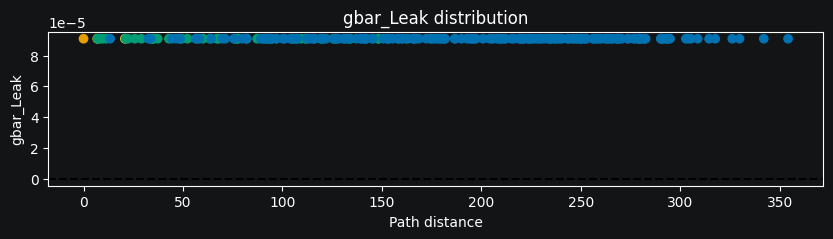

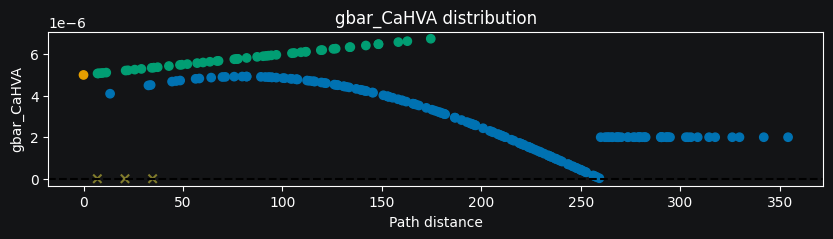

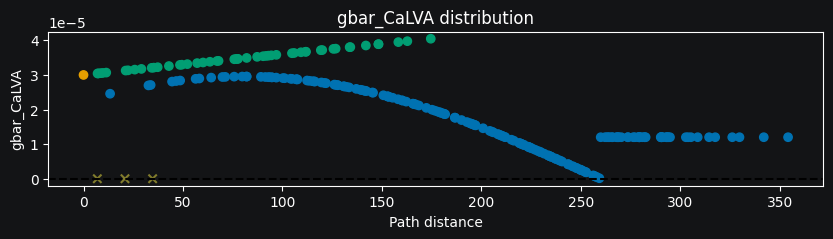

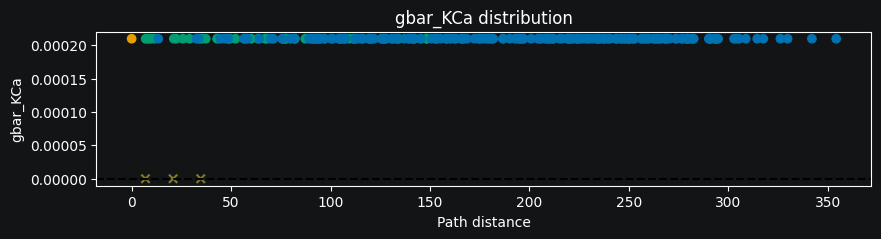

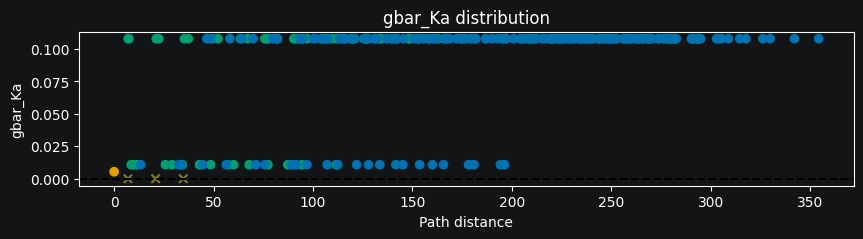

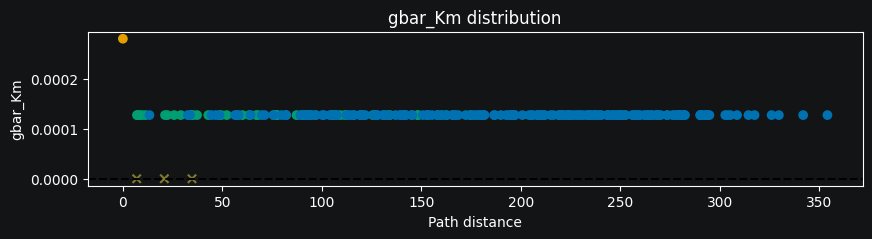

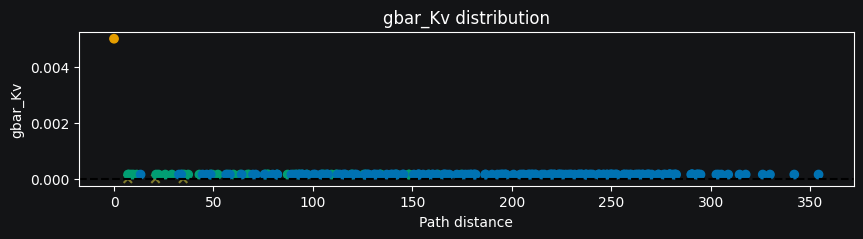

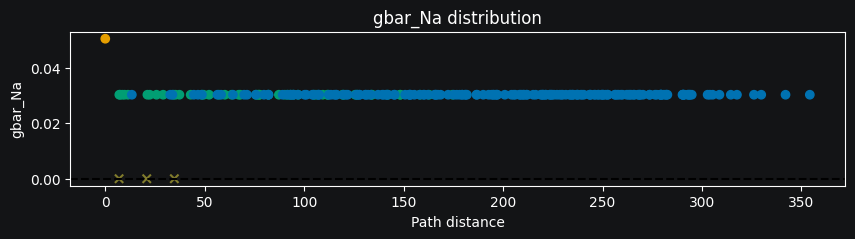

In [14]:
for param_name in model.conductances:
    fig, ax = plt.subplots(figsize=(10, 2))
    model.plot_param(param_name, ax=ax)

Let's also run a simulation before reduction so that we can compare the voltage traces berfore and after:

In [15]:
model.list_stimuli()

['hyperpolarizing_current',
 'depolarizing_current',
 '50_AMPA_apical',
 'attenuation_soma']

In [16]:
soma = model.sec_tree.soma
model.load_stimuli('depolarizing_current')

IClamp added to sec NeuronSection(idx=0) at loc 0.5.
Recording added to sec NeuronSection(idx=0) at loc 0.5.
Recording added to sec NeuronSection(idx=0) at loc 0.5.
Recording added to sec NeuronSection(idx=0) at loc 0.5.


In [17]:
model.run(1000)

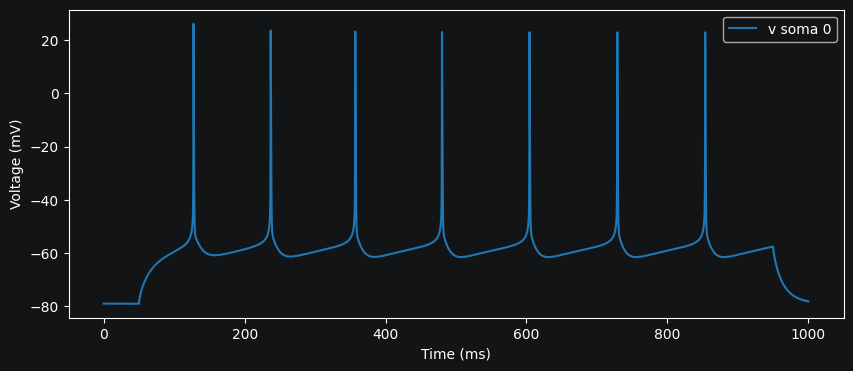

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
model.simulator.plot_voltage(ax=ax)
t, v_orig = model.simulator.t, model.simulator.recordings['v'][soma(0.5)]

# Reduction

Now, let’s consider a scenario where we want to reduce the entire apical subtree of the cell to a single equivalent cylinder. To accomplish this reduction, we need to select a section that serves as the root of the subtree we want to merge. As you might notice at the section tree plot above, section 9 is the root of the entire apical dendrite. Let's select this section for reduction:

In [19]:
root = model.sec_tree[9]

We can visualize the geometry of the section before reduction:

<Axes: title={'center': 'Radius Distribution - Section 9 (apic)'}, xlabel='Distance (µm)', ylabel='Radius (µm)'>

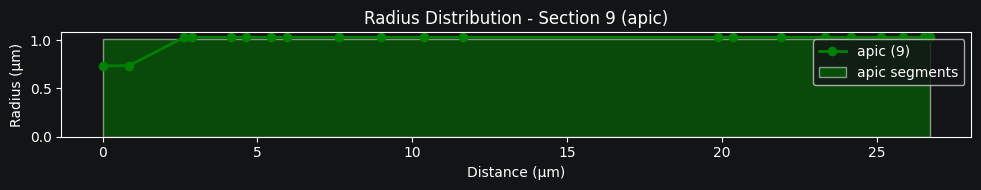

In [20]:
fig, ax = plt.subplots(figsize=(10, 2))
root.plot_radii(ax=ax)

Now we can use the `reduce_subtree` method to run the reduction algorithm, calculate the properties of the equivalent cylinder, and replace the entire subtree with a single section. We set the fit parameter to True to fit a polynomial to the channel distributions. This allows us to represent the channel distribution efficiently with just a few coefficients instead of storing values for each segment explicitly. 

Note that the algorithm doesn't currently support reduction with stimuli or recordings in the subtree. In our case, this isn't an issue since we record and stimulate only at the soma.

In [21]:
data = model.reduce_subtree(root, fit=True)

CableParams(length=764.4908970853801, diam=2.5167725013593345, space_const=831.9329527514925, cm=2.0, rm=11000.0, ra=100.0, e_pas=-79.0, electrotonic_length=0.9189333041285863)
Sorted SectionTree(root=NeuronSection(idx=0), num_nodes=45).
Sorted PointTree(root=Point(idx=0), num_nodes=2048).
Sorted SegmentTree(root=NeuronSegment(idx=0), num_nodes=219).
Sorted SegmentTree(root=NeuronSegment(idx=0), num_nodes=62).
Sorted PointTree(root=Point(idx=0), num_nodes=396).
Interpolated for ids []


(model.py, line 776)
Using the last valid fit (degree=6). Maximum residual: 1.7407861052682894e-07
(model.py, line 1511)
Using the last valid fit (degree=6). Maximum residual: 0.002857036610448435
(model.py, line 1511)
(model.py, line 751)
(model.py, line 776)
(model.py, line 776)


Let's visualize the mapping from original to reduced segments. Each point on the plot represents an original segment, with the x-axis showing its normalized distance along the  subtree. The colors indicate how the original segments map to the segment of the reduced section.

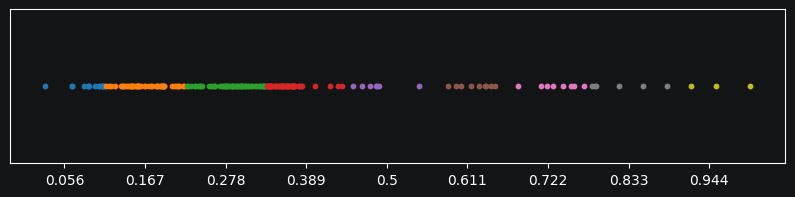

In [22]:
segs_to_reduced_segs = data['segs_to_reduced_segs']
segs_to_locs = data['segs_to_locs']
fig, ax = plt.subplots(figsize=(10, 2))
reduced_segs = root.segments
reduced_seg_to_color = {seg: plt.cm.tab10.colors[i] for i, seg in enumerate(reduced_segs)}
ax.set_ylim(-1, 1)
for seg, loc in segs_to_locs.items():
    plt.scatter(loc, [0], s=10, color=reduced_seg_to_color[segs_to_reduced_segs[seg]])

norm_centers = np.round(np.array(root.seg_centers)/root.L, 3)
ax.set_xticks(norm_centers);
ax.set_xticklabels(norm_centers);
ax.set_yticks([]);

We have 9 segments in the reduced section. Let's now plot the section's geometry as we did before:

<Axes: title={'center': 'Radius Distribution - Section 9 (reduced_0)'}, xlabel='Distance (µm)', ylabel='Radius (µm)'>

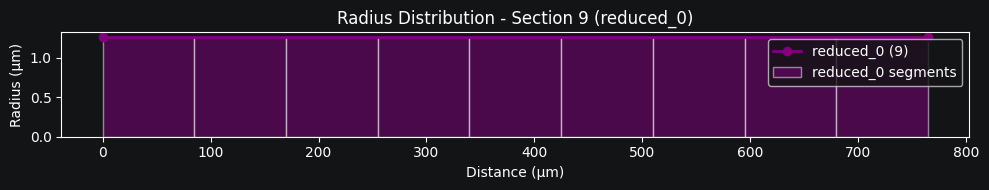

In [23]:
fig, ax = plt.subplots(figsize=(10, 2))
root.plot_radii(ax=ax)

Let's examine how the domains have changed. You'll notice a new `reduced_0` domain containing only the reduced section. There's also a new group with the same name that includes only the segments of the reduced section. This allows the section to have unique distribution parameters that represent the averaged distribution within the original subtree.

In [24]:
model.domains_to_mechs

{'axon': {'Leak'},
 'dend': {'CaDyn', 'CaHVA', 'CaLVA', 'KCa', 'Ka', 'Km', 'Kv', 'Leak', 'Na'},
 'soma': {'CaDyn', 'CaHVA', 'CaLVA', 'KCa', 'Ka', 'Km', 'Kv', 'Leak', 'Na'},
 'reduced_0': {'CaDyn',
  'CaHVA',
  'CaLVA',
  'KCa',
  'Ka',
  'Km',
  'Kv',
  'Leak',
  'Na'}}

In [25]:
model.groups

{'all': SegmentGroup("all", domains=['axon', 'dend', 'soma', 'reduced_0']),
 'axonal': SegmentGroup("axonal", domains=['axon']),
 'dendritic': SegmentGroup("dendritic", domains=['dend']),
 'somatic': SegmentGroup("somatic", domains=['soma']),
 'dendritic_thin': SegmentGroup("dendritic_thin", domains=['dend'], section_diam(None, 0.8)),
 'dendritic_thick': SegmentGroup("dendritic_thick", domains=['dend'], section_diam(0.8, None)),
 'basal': SegmentGroup("basal", domains=['dend']),
 'reduced_0': SegmentGroup("reduced_0", domains=['reduced_0'])}

Let's examine how the model parameters have changed. Notice that we have a new `reduced_0` group and its associated polynomial distributions with their coefficients.

In [26]:
model.params

{'cm': {'all': constant({'value': 2}),
  'somatic': constant({'value': 1}),
  'reduced_0': constant({'value': 2.0})},
 'Ra': {'all': constant({'value': 100}),
  'reduced_0': constant({'value': 100.0})},
 'gbar_Leak': {'all': constant({'value': 9.09090909090909e-05}),
  'reduced_0': constant({'value': 9.090909090909094e-05})},
 'e_Leak': {'all': constant({'value': -79}),
  'reduced_0': constant({'value': -79.0})},
 'depth_CaDyn': {'all': constant({'value': 0.1}),
  'reduced_0': constant({'value': 0.10000000000000003})},
 'taur_CaDyn': {'all': constant({'value': 50}),
  'reduced_0': constant({'value': 50.0})},
 'cainf_CaDyn': {'all': constant({'value': 0.0001}),
  'reduced_0': constant({'value': 0.00010000000000000006})},
 'gamma_CaDyn': {'all': constant({'value': 1}),
  'reduced_0': constant({'value': 1.0})},
 'kt_CaDyn': {'all': constant({'value': 0}),
  'reduced_0': constant({'value': -0.0})},
 'kd_CaDyn': {'all': constant({'value': 0}),
  'reduced_0': constant({'value': -0.0})},
 'gb

Let's plot the parameter distributions in the reduced model:

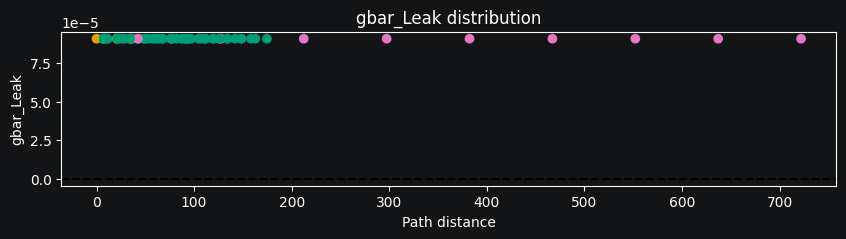

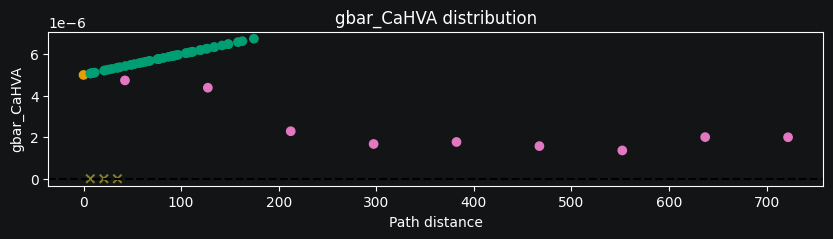

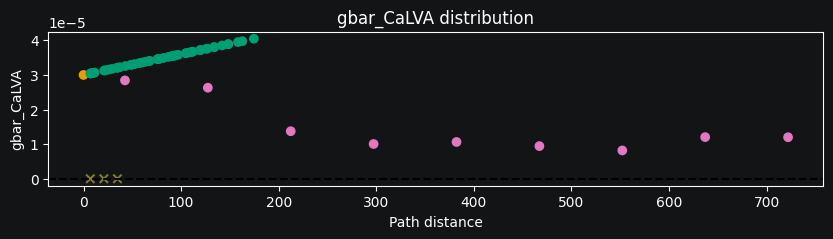

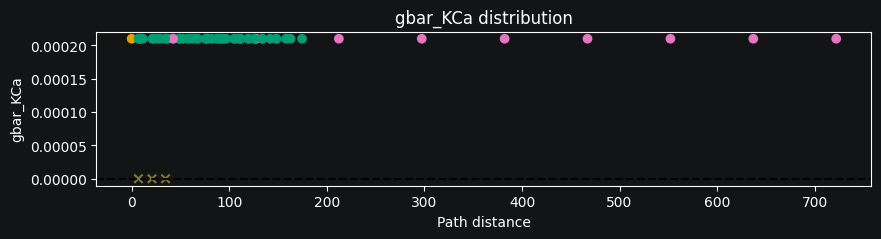

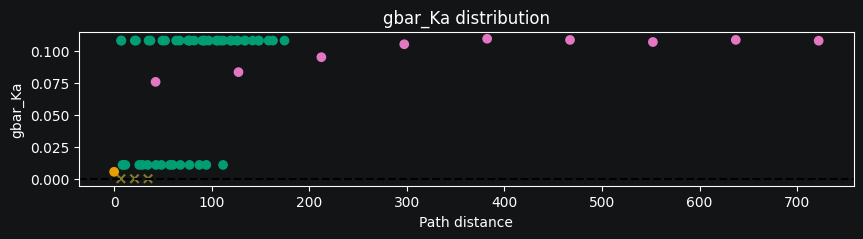

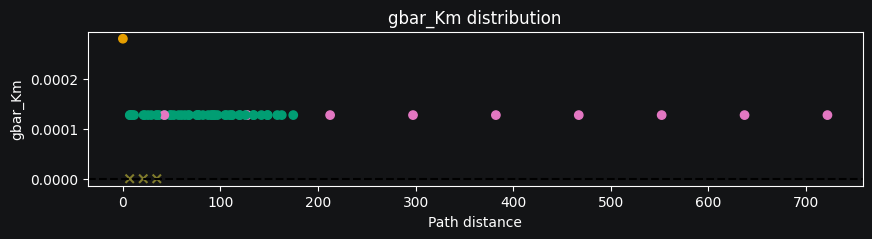

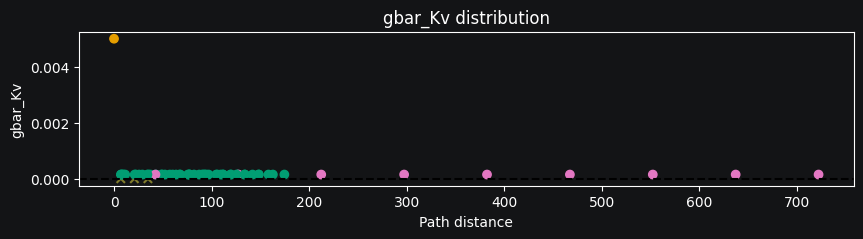

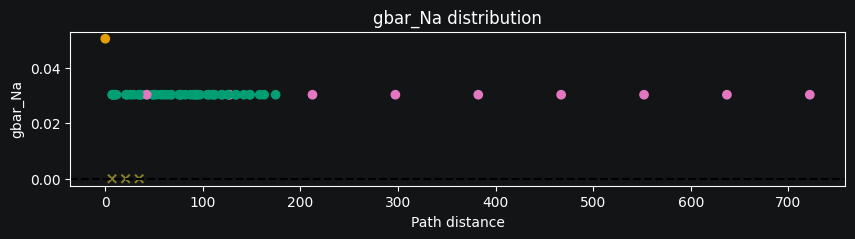

In [27]:
for param_name in model.conductances:
    fig, ax = plt.subplots(figsize=(10, 2))
    model.plot_param(param_name, ax=ax)

Finally, we can plot the section tree to see how the cell looks after reduction

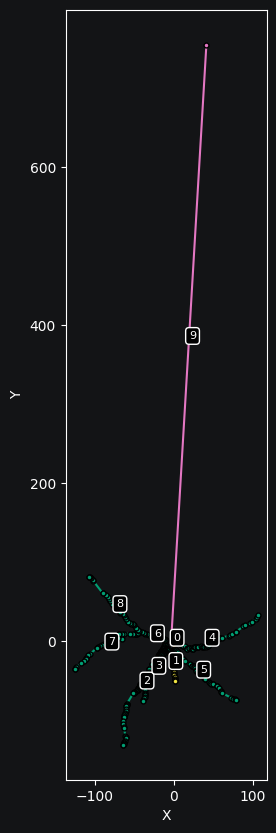

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
model.sec_tree.plot(ax, 
                    show_points=True,
                    show_lines=True,
                    annotate=True)

Let's run a simulation using the reduced model and compare the results to the original model output.

In [29]:
model.run(1000)

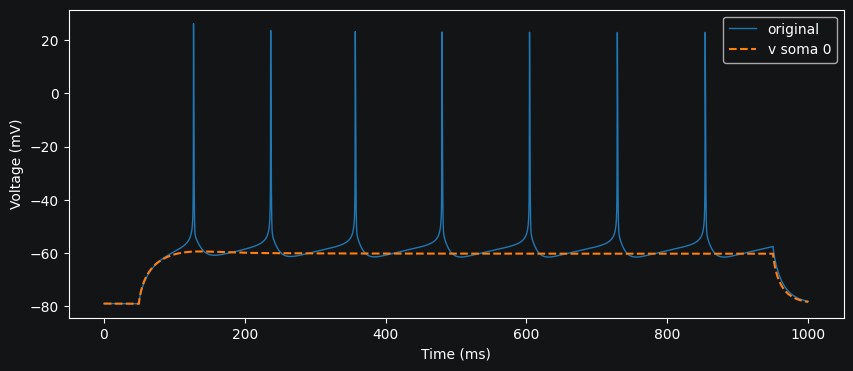

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(t, v_orig, color='C0', linestyle='-', zorder=0, lw=1, label='original')
model.simulator.plot_voltage(ax=ax, linestyle='--', color='C1')

Let's slightly increase the current amplitude and run the simulation again to match the original model:

In [31]:
print(f"Initial amplitude: {model.iclamps[soma(0.5)].amp} nA")
model.iclamps[soma(0.5)].amp= 0.172
print(f"New amplitude: {model.iclamps[soma(0.5)].amp} nA")

Initial amplitude: 0.162 nA
New amplitude: 0.172 nA


In [32]:
model.run(1000)

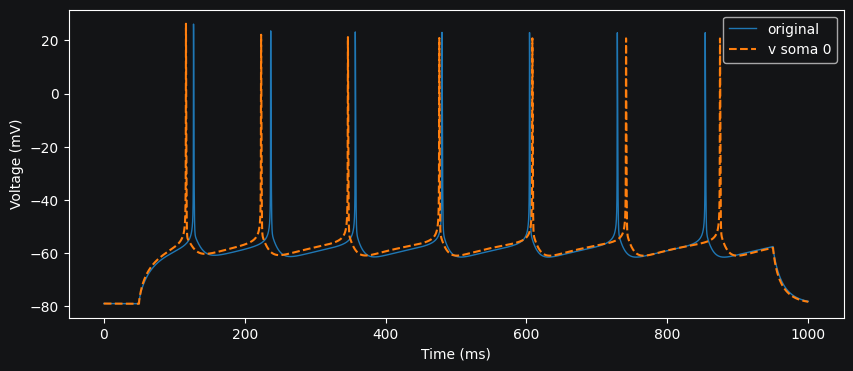

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(t, v_orig, color='C0', linestyle='-', zorder=0, lw=1, label='original')
model.simulator.plot_voltage(ax=ax, linestyle='--', color='C1')